# Allen Glancy - 4358685

I have made a model to predict the stock price. I have used linear regression, Random forest regression and Lasso Regression.

Comparison:
Linear Regression:
The model has the lowest mean MSE (0.59) among all three models, indicating that, on average, it has the smallest squared difference between actual and predicted values.
The standard deviation of MSE (0.72) suggests that the model's performance is relatively consistent across different folds.
Random Forest Regression:
The model achieves a perfect R-squared value of 1.00, indicating that it explains all the variability in the target variable (at least on the training data).
The mean MSE (1.43) is higher than that of Linear Regression, indicating a larger average squared difference between actual and predicted values.
Lasso Regression:
The model has the highest mean MSE (1.82) among all three models, indicating a larger average squared difference between actual and predicted values.
The standard deviation of MSE (2.89) suggests that the model's performance varies significantly across different folds.

Performing linear regression, lasso regression, and random forest regression entails certain risks. Linear regression can be sensitive to outliers, assumes a linear relationship between variables, and may overfit without regularization. Lasso regression offers feature selection but might exclude important features and is unstable with highly correlated variables. Selecting the right regularization strength is crucial. Random forest regression is less prone to overfitting but requires careful hyperparameter tuning and can be computationally expensive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("C:/Users/allen/Desktop/Microsoft_Stock.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


DATA PREPROCESSING

In [4]:
# Converting  the 'Date' column to a datetime data type
data['Date'] = pd.to_datetime(data['Date'])


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Open    1511 non-null   float64       
 2   High    1511 non-null   float64       
 3   Low     1511 non-null   float64       
 4   Close   1511 non-null   float64       
 5   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 71.0 KB


In [6]:
# checking null values
data.isnull().sum()


Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [8]:
# setting date as index
data.set_index('Date', inplace=True)


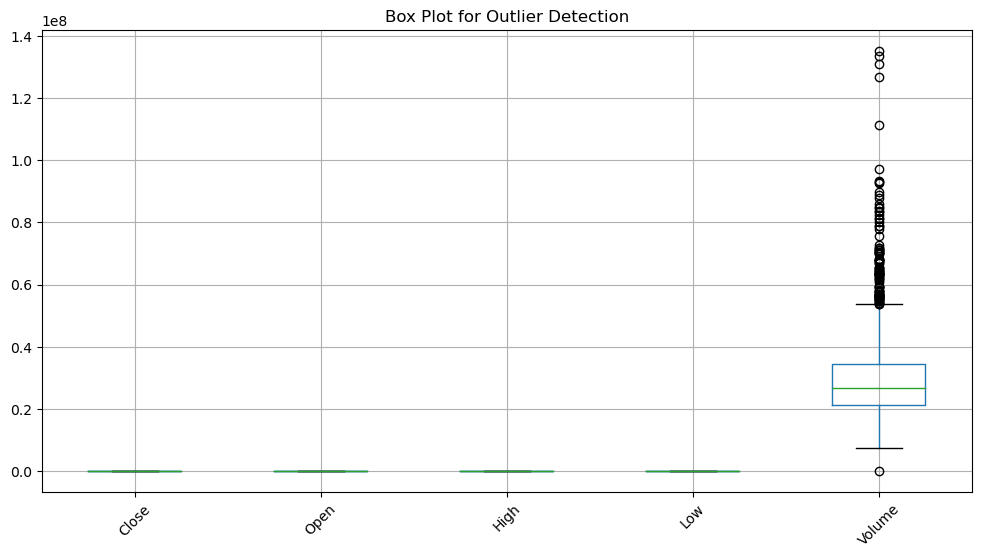

In [9]:
# checking for any outliers
plt.figure(figsize=(12, 6))
data[['Close', 'Open', 'High', 'Low', 'Volume']].boxplot()
plt.title('Box Plot for Outlier Detection')
plt.xticks(rotation=45)
plt.show()

FEATURE ENGINEERING

Creating new features from the existing ones that might be relevant for the prediction. 


In [10]:
# Daily Return (percentage change between consecutive closing prices)
data['Daily_Return'] = data['Close'].pct_change()

# Moving Averages 7-day and 30-day moving averages
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_30'] = data['Close'].rolling(window=30).mean()

# Volatility 
data['Volatility'] = data['High'] - data['Low']



By calculating the daily return, moving averages, and volatility, I am creating additional features that can provide valuable insights into the stock's behavior and help make more informed decisions when building predictive models for stock price movements. These features can serve as inputs to your regression model for predicting the closing prices.


In [11]:
data.isna().sum()

Open             0
High             0
Low              0
Close            0
Volume           0
Daily_Return     1
MA_7             6
MA_30           29
Volatility       0
dtype: int64

In [12]:
data = data.sort_values(by='Date')

In [13]:
# Impute missing values using forward fill
data['Daily_Return'] = data['Daily_Return'].fillna(method='bfill')
data['MA_7'] = data['MA_7'].fillna(method='bfill')
data['MA_30'] = data['MA_30'].fillna(method='bfill')


In [14]:
data.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Daily_Return    0
MA_7            0
MA_30           0
Volatility      0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1511 non-null   float64
 1   High          1511 non-null   float64
 2   Low           1511 non-null   float64
 3   Close         1511 non-null   float64
 4   Volume        1511 non-null   int64  
 5   Daily_Return  1511 non-null   float64
 6   MA_7          1511 non-null   float64
 7   MA_30         1511 non-null   float64
 8   Volatility    1511 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 118.0 KB


In [16]:
# removing High and Low feature 
data.drop(['High','Low'],axis=1)

,Open,Close,Volume,Daily_Return,MA_7,MA_30,Volatility
Date,,,,,,,
2015-04-01 16:00:00,40.60,40.72,36865322,-0.010560,41.244286,44.679333,0.45
2015-04-02 16:00:00,40.66,40.29,37487476,-0.010560,41.244286,44.679333,0.62
2015-04-06 16:00:00,40.34,41.55,39223692,0.031273,41.244286,44.679333,1.60
2015-04-07 16:00:00,41.61,41.53,28809375,-0.000481,41.244286,44.679333,0.60
2015-04-08 16:00:00,41.48,41.42,24753438,-0.002649,41.244286,44.679333,0.65
...,...,...,...,...,...,...,...
2021-03-25 16:00:00,235.30,232.34,34061853,-0.013251,234.211429,235.367000,5.37
2021-03-26 16:00:00,231.55,236.48,25479853,0.017819,234.131429,235.100000,5.16
2021-03-29 16:00:00,236.59,235.24,25227455,-0.005244,234.777143,234.775000,4.92


MODEL

In [17]:
# Separate features (X) and target (y)
X = data.drop('Close', axis=1)
y = data['Close']
# standarisation 
scaler = StandardScaler()
# Fit and transform the feature data
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Random Forest Regression

In [18]:
# Creating the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Squared Error (MSE): 1.36
R-squared (R2): 1.00


In [19]:
#Creating the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")



Mean Squared Error (MSE): 0.42
R-squared (R2): 1.00


In [20]:
# Creating the Lasso Regression model
alpha = 0.01  
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) for Lasso Regression: {mse:.2f}")
print(f"R-squared (R2) for Lasso Regression: {r2:.2f}")

Mean Squared Error (MSE) for Lasso Regression: 0.73
R-squared (R2) for Lasso Regression: 1.00


C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.368e+02, tolerance: 3.939e+02
  model = cd_fast.enet_coordinate_descent(


Cross Validation

In [21]:
# Performing k-fold cross-validation
num_folds = 5
mse_scores = cross_val_score(lr_model, X, y, cv=num_folds, scoring='neg_mean_squared_error')
mean_mse = -np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean Squared Error (MSE) for each fold: {[-mse for mse in mse_scores]}")
print(f"Mean MSE: {mean_mse:.2f}")
print(f"Standard Deviation of MSE: {std_mse:.2f}")

Mean Squared Error (MSE) for each fold: [0.3933449461072885, 0.10260060127476654, 0.201996027488004, 0.23237868493027303, 2.013204845449541]
Mean MSE: 0.59
Standard Deviation of MSE: 0.72


In [22]:
# Defining the hyperparameter grid to search through
param_grid = {
    'n_estimators': [50, 100, 200],      
    'max_depth': [None, 10, 20],         
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4]       
}


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 1.43
R-squared (R2): 1.00


In [23]:
# Performing k-fold cross-validation 
num_folds = 5
mse_scores = cross_val_score(lasso_model, X, y, cv=num_folds, scoring='neg_mean_squared_error')
mean_mse = -np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean Squared Error (MSE) for each fold: {[-mse for mse in mse_scores]}")
print(f"Mean MSE: {mean_mse:.2f}")
print(f"Standard Deviation of MSE: {std_mse:.2f}")

Mean Squared Error (MSE) for each fold: [0.2248435545444474, 0.07856995083339417, 0.49451092747463493, 0.7452744524044143, 7.580955018056984]
Mean MSE: 1.82
Standard Deviation of MSE: 2.89


C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+03, tolerance: 3.576e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+03, tolerance: 4.099e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\allen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+03, toleranc